In [1]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten, MaxPooling2D, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model, model_from_json, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.metrics import Precision, Recall
from keras.utils import to_categorical
import os, numpy as np
from skimage.transform import resize

Using TensorFlow backend.


In [2]:
X = np.load("../input/covidx/Copy of trainx.npy")
Y = np.load("../input/covidx/trainy.npy")

bins = {}

for i in range(Y.shape[0]):
    if Y[i] not in bins:
        bins[Y[i]] = []
    bins[Y[i]].append(X[i])
    
for b in bins:
    bins[b] = np.array(bins[b])
    
del X
del Y

In [3]:
from skimage.transform import rotate, AffineTransform, warp
from skimage.util import random_noise
from skimage.filters import gaussian
from PIL import Image 
import cv2

augment_image = {}

def anticlockwise_rotation(image):
    angle= random.randint(0,180)
    image = rotate(image, angle)
    image = cv2.normalize(image, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_8U)
    return image

augment_image[0] = anticlockwise_rotation

def clockwise_rotation(image):
    angle= random.randint(0,180)
    image = rotate(image, -angle)
    image = cv2.normalize(image, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_8U)
    return image

augment_image[1] = clockwise_rotation

def h_flip(image):
    return  np.fliplr(image)

augment_image[2] = h_flip

def v_flip(image):
    return np.flipud(image)

augment_image[3] = v_flip

def add_noise(image):
    image = random_noise(image)
    image = cv2.normalize(image, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_8U)
    return image 

augment_image[4] = add_noise

def blur_image(image):
    image = gaussian(image, sigma = random.uniform(0, 1), multichannel=True)
    image = cv2.normalize(image, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_8U)
    return image

augment_image[5] = blur_image

#I would not recommend warp_shifting, because it distorts image, but can be used in many use case like 
#classifying blur and non-blur images
def warp_shift(image): 
    transform = AffineTransform(translation=(0,40))  #chose x,y values according to your convinience
    warp_image = warp(image, transform, mode="wrap")
    return warp_image

In [4]:
import random

def augment_covid(data, no=1200):
    n = data.shape[0]
    i = 0
    new_data = list(data)
    while len(new_data) < no:
        times_to_augment = random.randint(1, 3)
        img = data[i]
        for j in range(times_to_augment):
            r = random.randint(0, 5)
            img = augment_image[r](img)
        print(i)        
        new_data.append(img)
        i += 1
        i %= n
    
    return new_data

In [5]:
for b in bins:
    bins[b] = augment_covid(bins[b])
    bins[b] = np.array(bins[b])
    np.random.shuffle(bins[b])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134


In [6]:
training_no = {}
training_samples = 200
for b in bins:
    training_no[b] = len(bins[b]) - training_samples

In [7]:
X_train = []
Y_train = []
X_test = []
Y_test = []
for b in bins:
    X_train = X_train + list(bins[b][:training_no[b]])
    X_test = X_test + list(bins[b][training_no[b]:])
    Y_train = Y_train + [b]*training_no[b]
    Y_test = Y_test + [b]*training_samples

In [8]:
input_shape = (128, 128)
Y_train = to_categorical(np.array(Y_train, dtype='int32'), 3)
Y_test = to_categorical(np.array(Y_test, dtype='int32'), 3)

In [9]:
for i in range(len(X_train)):
    if not (i%100):
        print(i)
    X_train[i] = resize(X_train[i], input_shape)
    X_train[i] = cv2.normalize(X_train[i], None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_8U)

for i in range(len(X_test)):
    X_test[i] = resize(X_test[i], input_shape)
    X_test[i] = cv2.normalize(X_test[i], None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_8U)


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900


In [10]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [11]:
def save_model(model, name):
    # serialize model to JSON
    model_json = model.to_json()
    with open("model_" + name + ".json", "w") as json_file:
        json_file.write(model_json)
    model.save_weights("model_" + name + ".h5")
    print("Saved " + name + " to disk")

In [12]:
def load_model(json_file_name, weights_file_name):
    json_file = open(json_file_name, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights(weights_file_name)
    print("Loaded model from disk")
    return loaded_model

In [13]:
from sklearn.metrics import confusion_matrix

def get_params(model, X, Y):
    scores = model.evaluate(X, Y, verbose=0)
    for i in range(len(scores)):
        print("%s: %.2f%%" % (model.metrics_names[i], scores[i]*100))
    
    m = (2 * scores[1] * scores[2]) / (scores[1] + scores[2])
    print("%s: %.2f%%" % ("F1 Score", m*100))
    Y_P = model.predict(X)
    matrix = confusion_matrix(Y.argmax(axis=1), Y_P.argmax(axis=1))
    print("Confusion Matrix is:")
    print(matrix)

In [14]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [15]:
batch_size = 64

def get_resnet_model():
    input_shape = (128,128,3)
    output_classes = 3
    num_filters = 16
    depth = 20  # depth = 6n+2 and number of residual blocks = n
                # inital layer and output layer rest all residual blocks
    
    no_residual_blocks = int((depth-2)/6)
        
    inputs = Input(input_shape)
    
    x = resnet_layer(inputs=inputs)
    
    for stack in range(3):
        for res_block in range(no_residual_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    x = AveragePooling2D(pool_size=8)(x)
    x = Flatten()(x)
    x = Dense(units=1024, activation='relu')(x)
    x = Dropout(0.2)(x)
    
    outputs = Dense(3, activation='softmax',kernel_initializer='he_normal')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [16]:
model = get_resnet_model()
model.summary()
model.compile(  optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 16) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

imagegen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    vertical_flip=True
)

imagegen.fit(X_train)

image_generator = imagegen.flow(X_train, Y_train, batch_size=batch_size)

model.fit_generator(image_generator,
                    steps_per_epoch=len(X_train) // batch_size, epochs=8)

In [17]:
model.fit(X_train, Y_train, batch_size, epochs = 32)

Epoch 1/32
3000/3000 [==============================] - 22s 7ms/step - loss: 1.5383 - accuracy: 0.7333
Epoch 2/32
3000/3000 [==============================] - 12s 4ms/step - loss: 0.4513 - accuracy: 0.8990
Epoch 3/32
3000/3000 [==============================] - 12s 4ms/step - loss: 0.3549 - accuracy: 0.9320
Epoch 4/32
3000/3000 [==============================] - 12s 4ms/step - loss: 0.3200 - accuracy: 0.9417
Epoch 5/32
3000/3000 [==============================] - 12s 4ms/step - loss: 0.2903 - accuracy: 0.9553
Epoch 6/32
3000/3000 [==============================] - 12s 4ms/step - loss: 0.2821 - accuracy: 0.9550
Epoch 7/32
3000/3000 [==============================] - 12s 4ms/step - loss: 0.2634 - accuracy: 0.9577
Epoch 8/32
3000/3000 [==============================] - 12s 4ms/step - loss: 0.2329 - accuracy: 0.9723
Epoch 9/32
3000/3000 [==============================] - 12s 4ms/step - loss: 0.2052 - accuracy: 0.9793
Epoch 10/32
3000/3000 [==============================] - 12s 4ms/step - l

In [18]:
save_model(model, "final_resnet_20_200")

Saved final_resnet_20_200 to disk


In [19]:
loaded_model = load_model("../input/covidresnet20/model_final_resnet_20_200.json", "../input/covidresnet20/model_final_resnet_20_200.h5")
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', Precision(), Recall()])
loaded_model.summary()

Loaded model from disk
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 16) 0           batch_normalization_1[0][0]      
_____________________________________________________________________

In [20]:
get_params(loaded_model, X_test, Y_test)

loss: 16.19%
accuracy: 98.83%
precision_1: 99.00%
recall_1: 98.83%
F1 Score: 98.92%
Confusion Matrix is:
[[200   0   0]
 [  1 194   5]
 [  1   0 199]]


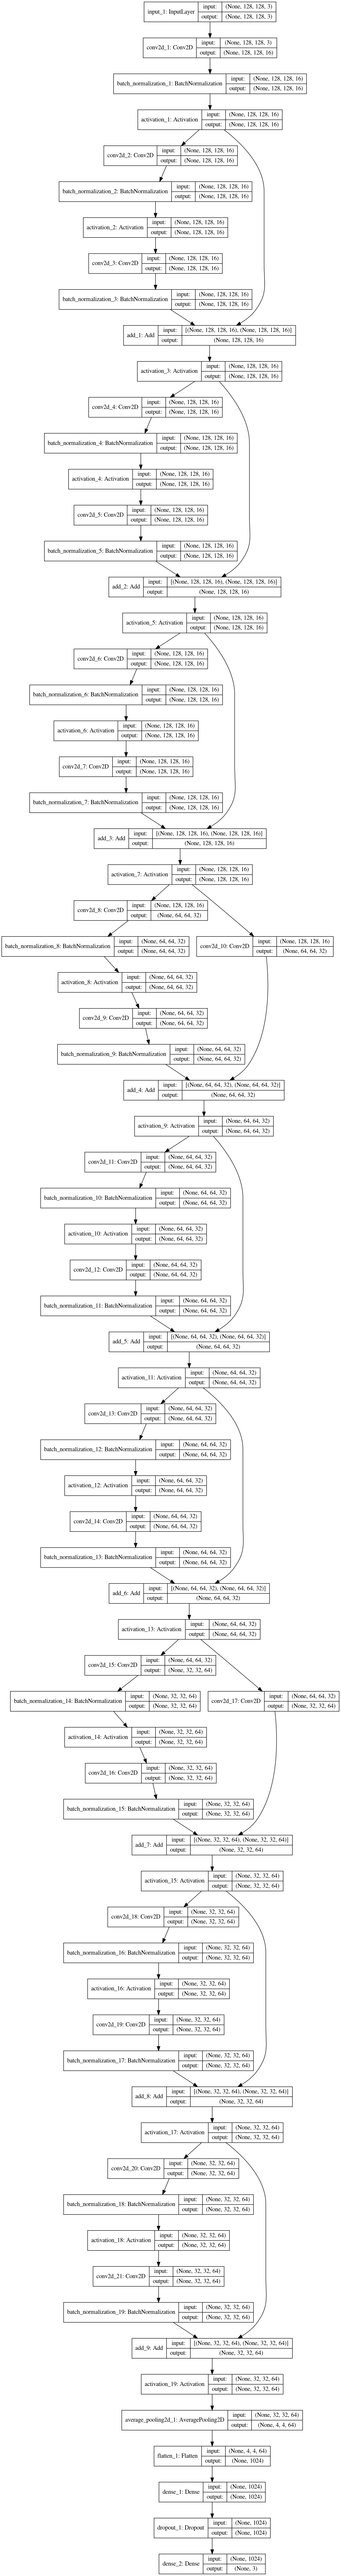

In [21]:
from keras.utils.vis_utils import plot_model
plot_model(loaded_model,show_shapes = True, show_layer_names = True)